# Re-estimating newspaper article genre counts

We start with re-estimating counts produced by fasttext. First get the confusion matrix of fasttext on the TRAIN data. This code comes from the Jupyter notebook confusion.ipynb in the fasttext-runs directory:

In [1]:
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re

DATADIR = "/home/erikt/projects/newsgac/data-large/telegraaf.cwi"
TRAIN = "TRAIN"
TEST = "TRAIN.20191004:14:29:50.labels"

def shortenLabel(label):
    return(re.sub("__label__","",label))

def getLabels(inFileName):
    labels = []
    inFile = open(inFileName,"r")
    for line in inFile:
        label = re.sub("\s.*$","",line)
        labels.append(shortenLabel(label))
    inFile.close()
    return(labels)

def makeConfusionMatrix(goldLabels,predictedLabels):
    confusionMatrix = {}
    for i in range(0,len(goldLabels)):
        goldLabel = goldLabels[i]
        predictedLabel = predictedLabels[i]
        if not goldLabel in confusionMatrix: confusionMatrix[goldLabel] = {}
        if not predictedLabel in confusionMatrix[goldLabel]: 
            confusionMatrix[goldLabel][predictedLabel] = 0
        confusionMatrix[goldLabel][predictedLabel] += 1
    for goldLabel in confusionMatrix:
        for predictedLabel in confusionMatrix:
            if not predictedLabel in confusionMatrix[goldLabel]: 
                confusionMatrix[goldLabel][predictedLabel] = 0
    return(confusionMatrix)

def confusionMatrixToArray(confusionMatrix):
    labels = []
    for goldLabel in confusionMatrix: labels.append(goldLabel)
    labels = sorted(labels)
    confusionArray = []
    for goldLabel in labels:
        confusionArray.append([])
        for predictedLabel in labels:
            confusionArray[-1].append(confusionMatrix[goldLabel][predictedLabel])
    return(confusionArray,labels)

def arrayToPercentages(arrayIn):
    arrayOut = []
    for i in range(0,len(arrayIn)):
        arrayOut.append([])
        totalRow = sum(arrayIn[i])
        for j in range(0,len(arrayIn[i])): arrayOut[i].append(round(100*arrayIn[i][j]/totalRow))
    return(arrayOut)

def cm(array,columnNames):
    arrayPerc = arrayToPercentages(array)
    df_cm = pd.DataFrame(arrayPerc, index = columnNames, columns = columnNames)
    plt.figure(figsize = (20,8))
    sn.set(font_scale=1.5)
    sn.heatmap(df_cm, annot=True,cmap="Blues")

def roundList(list,prec=1):
    return([round(x,prec) for x in list])
    
def makeTotalsEqual(list1,list2):
    sumList1 = sum(list1)
    sumList2 = sum(list2)
    outList = []
    for i in range(0,len(list1)): outList.append(list1[i]*sumList2/sumList1)
    return(outList)

def reEstimateBaseline(predictions,trainingPredictions,trainingGold):
    reEstimatedPredictions = []
    for i in range(0,len(predictions)):
        reEstimatedPredictions.append(predictions[i]*trainingGold[i]/trainingPredictions[i])
    return(makeTotalsEqual(reEstimatedPredictions,predictions))
    
def reEstimate(scoreList,confusionMatrix):
    reEstimatedScoreList = []
    columnTotals = computeColumnTotals(confusionMatrix) 
    for i in range(0,len(scoreList)):
        total = 0.0
        for column in range(0,len(scoreList)):
            total += scoreList[column]*confusionMatrix[i][column]/columnTotals[column]
        reEstimatedScoreList.append(total)
    return(roundList(makeTotalsEqual(reEstimatedScoreList,scoreList)))

def computeRowTotals(array):
    rowTotals = []
    for i in range(0,len(array)): rowTotals.append(sum(array[i]))
    return(rowTotals)

def computeColumnTotals(array):
    columnTotals = []
    if len(array) > 0: 
        for i in range(0,len(array[0])): columnTotals.append(sum([x[i] for x in array]))
    return(columnTotals)

def readNewspaperTitles(newspaperListFile):
    newspaperList = []
    inFile = open(newspaperListFile,"r")
    for line in inFile: newspaperList.append(line.strip())
    inFile.close()
    return(newspaperList)

def printCounts(labels,goldCounts,predictedCounts,summary=True):
    totalDeviance = 0.0
    counts = 0
    for i in range(0,len(labels)): 
        deviance = int(0.5+abs((goldCounts[i]-predictedCounts[i])))
        if predictedCounts[i] < goldCounts[i]: direction = "-"
        else: direction = "+"
        if not summary:
            print("{} {} ({} {}{}%)".format(labels[i],int(0.5+predictedCounts[i]),\
                                            deviance,direction,int(0.5+100*deviance/goldCounts[i])))
        counts += 1
        totalDeviance += int(0.5+100*deviance/goldCounts[i])
    print("Average deviance: {}%\n".format(int(0.5+totalDeviance/counts),"%"))

In [2]:
os.chdir(DATADIR)
goldLabels = getLabels(TRAIN)
predictedLabels = getLabels(TEST)
confusionMatrix = makeConfusionMatrix(goldLabels,predictedLabels)

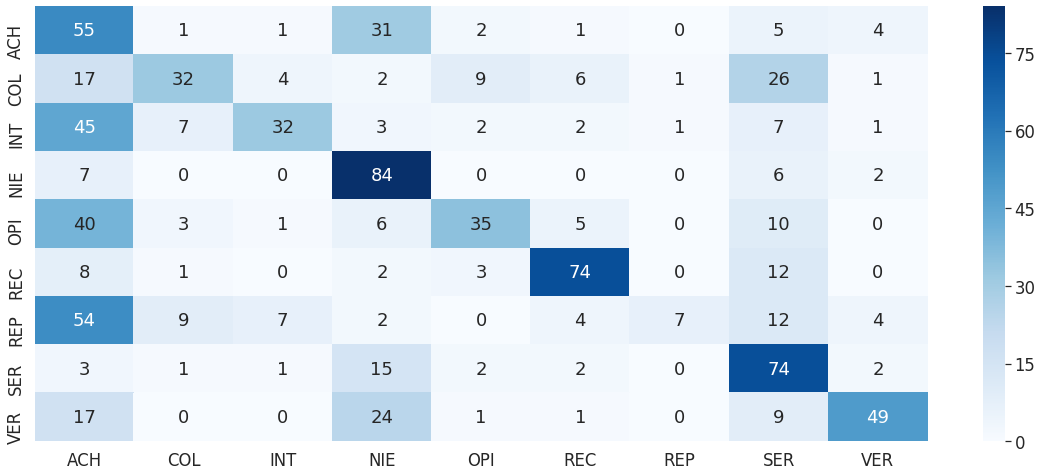

In [3]:
confusionArray,labels = confusionMatrixToArray(confusionMatrix)
cm(confusionArray,labels)

## Sanity checks

First: do we get the training data gold counts if we re-estimate the predicted training data counts? 

In [5]:
trainingGoldCounts = computeRowTotals(confusionArray)
trainingPredictedCounts = computeColumnTotals(confusionArray)

print("labels:                ",labels)
print("true distribution:     ",trainingGoldCounts)
print("predicted distribution:",trainingPredictedCounts)
print("re-estimation baseline:",reEstimateBaseline(trainingPredictedCounts,trainingPredictedCounts,trainingGoldCounts))
print("predicted re-estimated:",reEstimate(trainingPredictedCounts,confusionArray))

labels:                 ['ACH', 'COL', 'INT', 'NIE', 'OPI', 'REC', 'REP', 'SER', 'VER']
true distribution:      [1410, 223, 170, 4042, 247, 380, 137, 2127, 510]
predicted distribution: [1543, 147, 116, 4316, 188, 407, 20, 2084, 425]
re-estimation baseline: [1410.0, 223.0, 170.0, 4042.0, 247.0, 380.0, 137.0, 2127.0, 510.0]
predicted re-estimated: [1410.0, 223.0, 170.0, 4042.0, 247.0, 380.0, 137.0, 2127.0, 510.0]


Second: check if re-estimation improves the counts for the three newspapers in the data set:

In [6]:
NEWSPAPERTITLEFILE="TRAIN.newspapers"
NEWSPAPERTITLES=["05NRC_Handelsblad","06De_Telegraaf","08De_Volkskrant"]

goldCounts = list(np.unique(goldLabels,return_counts=True)[1])
predictedCounts = list(np.unique(predictedLabels,return_counts=True)[1])
print("ALL","predicted")
printCounts(labels,goldCounts,predictedCounts,summary=True)

newspaperTitles = readNewspaperTitles(NEWSPAPERTITLEFILE)
for newspaperTitle in NEWSPAPERTITLES:
    goldLabelsN = [goldLabels[i] for i in range(0,len(goldLabels)) 
                   if newspaperTitles[i] == newspaperTitle]
    predictedLabelsN = [predictedLabels[i] for i in range(0,len(predictedLabels)) \
                                           if newspaperTitles[i] == newspaperTitle]
    goldCountsN = list(np.unique(goldLabelsN,return_counts=True)[1])
    predictedCountsN = list(np.unique(predictedLabelsN,return_counts=True)[1])
    print(newspaperTitle,"predicted")
    printCounts(labels,goldCountsN,predictedCountsN,summary=True)
    print(newspaperTitle,"baseline re-estimated")
    printCounts(labels,goldCountsN,
                reEstimateBaseline(predictedCountsN,trainingPredictedCounts,trainingGoldCounts),summary=True)
    print(newspaperTitle,"re-estimated")
    printCounts(labels,goldCountsN,reEstimate(predictedCountsN,confusionArray),summary=True)

ALL predicted
Average deviance: 24%

05NRC_Handelsblad predicted
Average deviance: 29%

05NRC_Handelsblad baseline re-estimated
Average deviance: 10%

05NRC_Handelsblad re-estimated
Average deviance: 12%

06De_Telegraaf predicted
Average deviance: 24%

06De_Telegraaf baseline re-estimated
Average deviance: 13%

06De_Telegraaf re-estimated
Average deviance: 10%

08De_Volkskrant predicted
Average deviance: 26%

08De_Volkskrant baseline re-estimated
Average deviance: 8%

08De_Volkskrant re-estimated
Average deviance: 11%



## Re-estimate counts of large fasttext runs

In [20]:
RUNDIR = "/home/erikt/projects/newsgac/data-large/newsgac/"
LEARNER = "FST"
TYPEORG = "UNC"
TYPENEW = "REE"
GENREA = "ACH-"+LEARNER+"-"+TYPEORG
GENREZ = "VER-"+LEARNER+"-"+TYPEORG
DATEA = "date"
DATEZ = "weekday"

def changeName(name):
    return(re.sub(TYPEORG,TYPENEW,name))

def reEstimateDf(df,confusionArray):
    reEstimatedArray = []
    for rowIndex in range(0,len(df)):
        reEstimatedRow = list(df.loc[rowIndex,DATEA:DATEZ])
        reEstimatedRow.extend(reEstimate(list(df.loc[rowIndex,GENREA:GENREZ]),confusionArray))
        reEstimatedArray.append(reEstimatedRow)
    return(reEstimatedArray)

def changeColumnNames(columnNames):
    newColumnNames = []
    for i in range(0,len(columnNames)): newColumnNames.append(changeName(columnNames[i]))
    return(newColumnNames)

In [66]:
os.chdir(RUNDIR)
for fileName in os.listdir():
    if re.search(LEARNER+"-"+TYPEORG,fileName):
        df = pd.read_csv(fileName)
        reEstimatedArray = reEstimateDf(df,confusionArray)
        reEstimatedColumnNames = changeColumnNames(df.columns)
        reEstimatedDf = pd.DataFrame(reEstimatedArray,df.index,columns=reEstimatedColumnNames)
        reEstimatedDf.to_csv(changeName(fileName),index=False)

## Re-estimating SVM runs

First load newsgac modules for accessing the data and the pipelines of the platform. In order to have these available, do the following:

1. cd platform
2. pip instal .
3. load all dependencies with pip: pip install ... (for python-dotenv, sentry-sdk, pymodm, dill, lightgbm, celery, pynlpl and perhaps others)

In [4]:
from newsgac import config
from newsgac import database
from newsgac.data_sources import DataSource
from newsgac.pipelines import Pipeline

Define functions for loading datasets and pipelines:

In [5]:
def getDataset(datasetTitle):
    dataset = -1
    for d in DataSource.objects.all():
        if d.display_title == datasetTitle:
            dataset = d
            break
    return(dataset)

testTitle = "newsgac TEST.0 9 genres"
getDataset(testTitle).display_title == testTitle

True

In [6]:
def getPipeline(pipelineTitle):
    pipeline = -1
    for p in Pipeline.objects.all():
        if p.display_title.strip() == pipelineTitle:
            pipeline = p
            break
    return(pipeline)

testTitle = "newsgac TRAIN.0 svm"
getPipeline(testTitle).display_title == testTitle

True

Run the 12 pipelines on the 12 sections of the data set in order to obtain predictions for each article in the data set:

In [7]:
DATASETTITLE = "newsgac TEST.{0} 9 genres"
PIPELINETITLE = "newsgac TRAIN.{0} svm"
PARTS = ['0','1','2','3','4','5','6','7','8','9','A','B']

def evaluate(predictions,labels):
    correct = 0
    for i in range(0,len(labels)): 
        if predictions[i] == labels[i]: correct += 1
    return(round(correct/len(labels),4))

allLabels = []
allPredictions = []
for part in PARTS:
    dataset = getDataset(DATASETTITLE.format(part))
    articles = [article.raw_text for article in dataset.articles]
    labels = [article.label for article in dataset.articles]
    pipeline = getPipeline(PIPELINETITLE.format(part))
    predictions = pipeline.sk_pipeline.get().predict(articles)
    print(part,evaluate(predictions,labels))
    allLabels.extend(labels)
    allPredictions.extend(predictions)

0 0.6789
1 0.7151
2 0.6948
3 0.7004
4 0.685
5 0.6729
6 0.6103
7 0.6568
8 0.6829
9 0.6667
A 0.6836
B 0.6634


In [8]:
print("overall accuracy:",evaluate(allPredictions,allLabels))

overall accuracy: 0.6747


Create a confusion matrix:

In [11]:
matrixSVM = np.zeros((len(np.unique(allLabels)),len(np.unique(allPredictions))))
for i in range(0,len(allLabels)):
    matrixSVM[allLabels[i],allPredictions[i]] += 1

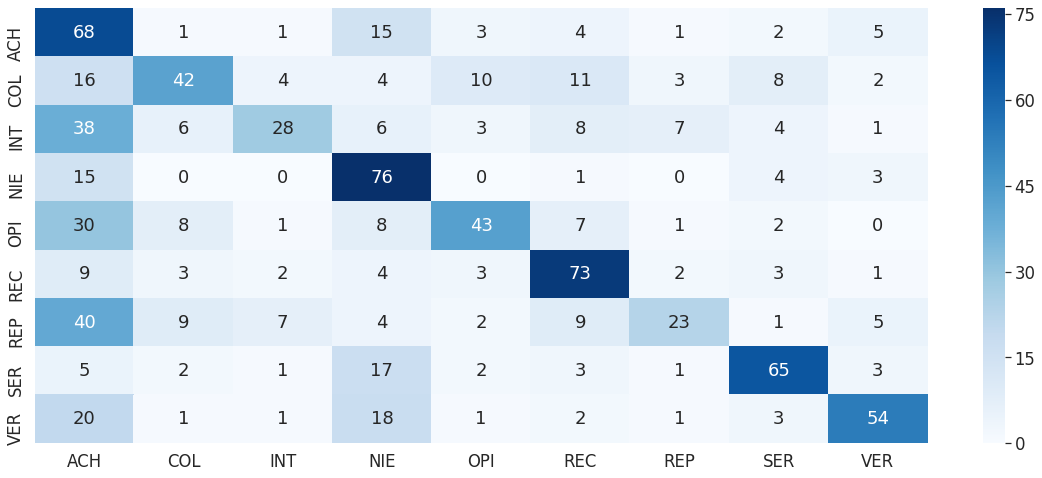

In [12]:
LABELS = ["ACH","COL","INT","NIE","OPI","REC","REP","SER","VER"]

cm(matrixSVM,LABELS)

## Sanity checks

First: do we get the training data gold counts if we re-estimate the predicted training data counts? 

In [14]:
trainingGoldCounts = computeRowTotals(matrixSVM)
trainingPredictedCounts = computeColumnTotals(matrixSVM)

print("labels:                ",LABELS)
print("true distribution:     ",trainingGoldCounts)
print("predicted distribution:",trainingPredictedCounts)
print("re-estimation baseline:",reEstimateBaseline(trainingPredictedCounts,trainingPredictedCounts,trainingGoldCounts))
print("predicted re-estimated:",reEstimate(trainingPredictedCounts,matrixSVM))

labels:                 ['ACH', 'COL', 'INT', 'NIE', 'OPI', 'REC', 'REP', 'SER', 'VER']
true distribution:      [1410.0, 223.0, 170.0, 4042.0, 247.0, 380.0, 137.0, 2127.0, 510.0]
predicted distribution: [2038.0, 214.0, 134.0, 3805.0, 251.0, 510.0, 111.0, 1627.0, 556.0]
re-estimation baseline: [1410.0, 223.0, 170.0, 4042.0, 247.0, 380.0, 137.0, 2127.0, 510.0]
predicted re-estimated: [1410.0, 223.0, 170.0, 4042.0, 247.0, 380.0, 137.0, 2127.0, 510.0]


Second: check if re-estimation improves the counts for the three newspapers in the data set:

In [ ]:
NEWSPAPERTITLEFILE="TRAIN.newspapers"
NEWSPAPERTITLES=["05NRC_Handelsblad","06De_Telegraaf","08De_Volkskrant"]

goldCounts = list(np.unique(goldLabels,return_counts=True)[1])
predictedCounts = list(np.unique(predictedLabels,return_counts=True)[1])
print("ALL","predicted")
printCounts(LABELS,goldCounts,predictedCounts,summary=True)

newspaperTitles = readNewspaperTitles(NEWSPAPERTITLEFILE)
for newspaperTitle in NEWSPAPERTITLES:
    goldLabelsN = [goldLabels[i] for i in range(0,len(goldLabels)) 
                   if newspaperTitles[i] == newspaperTitle]
    predictedLabelsN = [predictedLabels[i] for i in range(0,len(predictedLabels)) \
                                           if newspaperTitles[i] == newspaperTitle]
    goldCountsN = list(np.unique(goldLabelsN,return_counts=True)[1])
    predictedCountsN = list(np.unique(predictedLabelsN,return_counts=True)[1])
    print(newspaperTitle,"predicted")
    printCounts(LABELS,goldCountsN,predictedCountsN,summary=True)
    print(newspaperTitle,"baseline re-estimated")
    printCounts(LABELS,goldCountsN,
                reEstimateBaseline(predictedCountsN,trainingPredictedCounts,trainingGoldCounts),summary=True)
    print(newspaperTitle,"re-estimated")
    printCounts(LABELS,goldCountsN,reEstimate(predictedCountsN,confusionArray),summary=True)

While baseline re-estimated performs well on the fasttext output it degrades the counts when applied to the sv output.

## Re-estimate counts of large fasttext runs

In [22]:
LEARNER = "SVM"
GENREA = "ACH-"+LEARNER+"-"+TYPEORG
GENREZ = "VER-"+LEARNER+"-"+TYPEORG
       
os.chdir(RUNDIR)
for fileName in os.listdir():
    if re.search(LEARNER+"-"+TYPEORG,fileName):
        df = pd.read_csv(fileName)
        reEstimatedArray = reEstimateDf(df,matrixSVM)
        reEstimatedColumnNames = changeColumnNames(df.columns)
        reEstimatedDf = pd.DataFrame(reEstimatedArray,df.index,columns=reEstimatedColumnNames)
        reEstimatedDf.to_csv(changeName(fileName),index=False)